# Hipótesis Gaia (o el mundo de las margaritas)
## Introducción

James Lovelock propuso en 1983 una interesante hipótesis: la vida regula el clima para crear un entorno que la favorezca. Tal estabilidad autosuficiente se llama **homeostasis**, y emerge de la retroalimentación entre el clima y la biosfera. Esta idea se denomina a veces **Hipótesis Gaia** (griego para *madre tierra*). 

Para ilustrar esta hiótesis, Lovelock y Andrew Watson ilustraron la homeostasis del entorno global con *Daisyworld*, una Tierra hipotética que contiene solo margaritas de colores claros y oscuros. Si la tierra está demasiado fría, las margaritas oscuras proliferan porque están más calentitas. Esto aumenta la absorción de radiación solar globalmente, lo que calienta todavía más el planeta. Si hay demasiada energía, las margaritas amarillas proliferan, reflejando más luz solar al aumentando el albedo global, lo que enfría el sistema. Se trata en definitiva de procesos de **realimentación** entre el clima y el medio ambiente.

<img src="daisyworld.png" width="300px"></img>

Veamos cómo se puede definir un modelo matemático **muy muy sencillo** que preproduce estas ideas. 

## Algoritmo

### Luminosidad y Temperatura
Es el principal parámetro del modelo. Se conidera un forzamiento externo. Está basado en un equilibrio radiativo, y se modela como $q=\frac{LS_0}{4\sigma_{SB}}$ donde $L$ es un parámetro adimensional que usaremos para simular la evolución estelar (una suerte de potenciómetro solar).

La temperatura de equilibrio del planeta se obtiene mediante $T_e=q(1-A)$, donde $A$ es el albedo. La temperatura del suelo será mayor. Para un modelo con una atmósfera de una sola capa totalmente opaca se tiene que $T_s^4=2T_e^4$.

### Albedo y Margaritas
El estado del sistema está determinado por la cantidad de cada tipo de margaritas, que a su vez determian el albedo del planeta. Hay margaritas blancas (subíndice $w$), margaritas negras (subíndice $b$), y suelo desnudo (subíndice $G$). La cantidad de margaritas de cada tipo se mide como la fracción que ocupen sobre la superficie terrestre. Al ser fracciones del total, se cumple $C_G+C_w+C_b=1$.

Por otro lado, el albedo se obtiene como la suma ponderada $A=C_G A_G + C_w A_w + C_b A_b$. Tomaremos de manera simplificada pero cualitativamente correcta $A_b=0.25, A_w=0.75, A_G=0.5$.

### Temperatura y biología de las margaritas
Al absorber más energía, las margaritas negras están más calientes que el suelo, ocurriendo lo contrario para blancas. Se permitimos que haya conducción de calor entre estos tres elementos parametrizados por un parámetro $T_r=0.65$ tenemos

$T_w=T_s^4+(1-T_r)q(A-A_w)$

$T_b=T_s^4+(1-T_r)q(A-A_b)$

La temperatura de las margaritas afecta a su supervivencia, lo que se modela mediante una tasa de nacimientos con forma de parábola invertida centrada en $T_0=295.5 K$ con $b=0.003265 K^{-2}$.

$\beta_w=1-b(T_0-T_w)^2$

$\beta_b=1-b(T_0-T_b)^2$

### Evolución del sitema
Las margaritas mueren (de vejez) y nacen de acuerdo a las tasas que hemos calculado. Usamos el modelo basado en la siguiente ecuación diferencial:

$\frac{d C_w}{dt}=C_w(C_G\beta_w-D)$

$\frac{d C_w}{dt}=C_w(C_G\beta_w-D)$

El término $C_G\beta_w$ representa el nacimiento (proporcional al producto de la tasa de reproducibilidad por el suelo disponible), mientras que la constante $D=0.3$ es el número constante de muertes. Se multiplica por $C_w$ porque los cambios poblacionales son proporcionales a la población. La biología de las margaritas blancas y negras es idéntica por lo que sus ecuaciones son idénticas. **Sólo cambia su temperatura, que a fecta a su tasa de reproducibilidad**, y justo por ahí entra la realimentación con el sistema climático. 

Ambas ecuaciones se pueden discretizar y resolver de manera sencilla como:

$C_w(t+1)=C_w(t) + [C_w(C_G\beta_w-D)]\Delta t$

$C_b(t+1)=C_b(t) + [C_b(C_G\beta_w-D)]\Delta t$

Todas estas ecuaciones se puden resolver de manera iterativa, siguiendo los pasos:
1. se calcula el albedo como función de la cantidad de margaritas de cada tipo
1. estimamos la temperatura del suelo mediante balance radiativo
1. se obtienen las temperaturas de las margaritas (ligeramente superiores o inferiores al suelo)
1. con esto, podemos estimar las tasas de nuevos nacimiento
1. se da un paso de tiempo en el que algunas mueren (de vejez a un ritmo constante) y otras renacen en función de su tasa de crecimiento y del suelo disponible
1. se repite hasta que se alcance una situación estacionaria

## Programa (núcleo del modelo climático)

In [2]:
#Esta celda es el motor del problema
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

class DaisyWorldSol:
    def __init__(self, Cw, Cb, Tw, Ts, Tb, Niter):
        self.Cw=Cw
        self.Cb=Cb
        self.Tw=Tw
        self.Tb=Tb
        self.Ts=Ts
        self.Niter=Niter

class DaisyWorld:
    """Class to simulate the daisy world problem. """
    def __init__(self, L=1.2):
        self.L=L
        self.S0 = 1366
        self.SB = 5.67E-8
        self.Ab = 0.25
        self.Aw = 0.75
        self.Ag = 0.5
        self.D = 0.3
        self.q = L * self.S0 / 4.0 / self.SB

        self.Cw = 0.01
        self.Cb = 0.01

    def __str__(self):
        return "Current daisy world state: \n - Cw = "+str(self.Cw)+"\n - Cb = "+str(self.Cb)

    def albedo(self):
        return self.Cw*self.Aw + self.Cb*self.Ab + (1-self.Cw-self.Cb)*self.Ag

    def temp_s(self):
        return np.power(2*self.q*(1-self.albedo()), 1/4)

    def temp_daisies(self):
        tr = 0.65
        Ts = self.temp_s()
        A = self.albedo()
        Tw = np.power((1-tr)*self.q*(A-self.Aw) + np.power(Ts,4), 1/4)
        Tb = np.power((1-tr)*self.q*(A-self.Ab) + np.power(Ts,4), 1/4)
        return Tw, Tb

    def growth_rate(self):
        Tw, Tb = self.temp_daisies()
        T0 = 295.5
        b = 0.003265
        beta_w = 1 - b * np.power((T0-Tw), 2)
        beta_b = 1 - b * np.power((T0-Tb), 2)
        return np.maximum(beta_w, 0), np.maximum(beta_b, 0)

    def step(self):
        beta_w, beta_b = self.growth_rate()
        Cg = (1-self.Cw-self.Cb)
        dt = 1
        self.Cw += self.Cw*(Cg*beta_w - self.D) * dt
        self.Cb += self.Cb*(Cg*beta_b - self.D) * dt
#        if self.Cw < 0: self.Cw=0.001
#        if self.Cb < 0: self.Cb=0.001

    def equilibrate(self):
        MAX_ITER=5000
        C = np.zeros([2,MAX_ITER])
        T = np.zeros([3,MAX_ITER])
        i = 0
        tol = 1e-6
        while True:
            C[:,i] = [self.Cw, self.Cb]
            Tw, Tb = self.temp_daisies()
            T[:,i] = [Tw, self.temp_s(), Tb]
            Cw_old = self.Cw
            Cb_old = self.Cb
            self.step()
            if np.abs(Cw_old - self.Cw) < tol and np.abs(Cw_old - self.Cw) < tol:
                break
            i += 1
            if i == MAX_ITER:
                print("No convergence after "+str(MAX_ITER)+" iterations. STOP")
                exit(1)
        return DaisyWorldSol(C[0,0:i], C[1,0:i], T[0,0:i], T[1,0:i], T[2,0:i], i )

## Evolución hasta el equilibrio
Vamos a utilizar el modelo para representar la evolución del sistema, desde una condición inicial de una Tierra desnuda en el que se echan unas pocas semillas, hasta que se alcanza el equilibrio. El equilibrio alcanzado depende de la luminosidad, que se introduce mediente un deslizable interactivo.

In [25]:
#Esto define la operabilidad mediante widgets deslizables
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
%matplotlib nbagg

luminosity = widgets.FloatSlider(min=0.9, value=1.2, max=1.8, step=0.1,description='Luminosity:')
out = widgets.Output()
redraw = widgets.Button(description='Redibuja')

def update_plot(event=None):
    L = luminosity.value
    planet = DaisyWorld(L)
    sol = planet.equilibrate()
    
    with out:
        clear_output()
        fig, (ax0, ax1)= plt.subplots(1, 2, figsize=(8, 4))

        ax0.set_xlabel('# Iteracion')
        ax0.set_ylabel('Cobertura (%)')
        ax0.plot(sol.Cw,  color='y', lw=2, label='Blancas')
        ax0.plot(sol.Cb, color='b', lw=2, label='Negras')
        ax0.legend()

        ax1.set_xlabel('# Iteracion')
        ax1.set_ylabel('Temperatura (K)')
        ax1.plot(sol.Tw, color='y', lw=2, label='Blancas')
        ax1.plot(sol.Tb, color='b', lw=2, label='Negras')
        ax1.plot(sol.Ts, color='grey', lw=2, label='Suelo')
        ax1.yaxis.set_label_position("right")
        ax1.legend()
        plt.show()


#esperamos a que se pulse el botón para recalcular
redraw.on_click(update_plot)


#calculamos y pintamos caso por defecto
update_plot()
    
#layout con el interfaz
widgets.VBox([luminosity, redraw, out])

## Demostración de la Homeostasis
Simulamos la evolución solar aumentando prograsivamente la potencia solar (barremos $0.8<L<1.9$). Para cada valor, simulamos hasta obtener un estado estacionario y representamos la cantidad de cada tipo de margaritas. Además, dibujamos la temperatura del planeta (comparada con la que tendría si no hubiese vida). Se puede apreciar cómo en condiciones de baja luminosidad las margaritas oscuras proliferan, calentando el planeta. A la inversa, con mucha luminosidad las magaritas blancas están mejor adaptadas, lo que enfría la Tierra. 

Hay todo un rango de temperaturas donde la variabilidad de la Tierra está "suavizada" por la vida, en lugar de estar a expensas del forzamiento solar.

Por supuesto, cuando la radiación es demasiado baja, o demasiado alta, ningún tipo de margaritas puede sobrevivir, y el planeta decae hacia un yermo estéril.

<IPython.core.display.Javascript object>


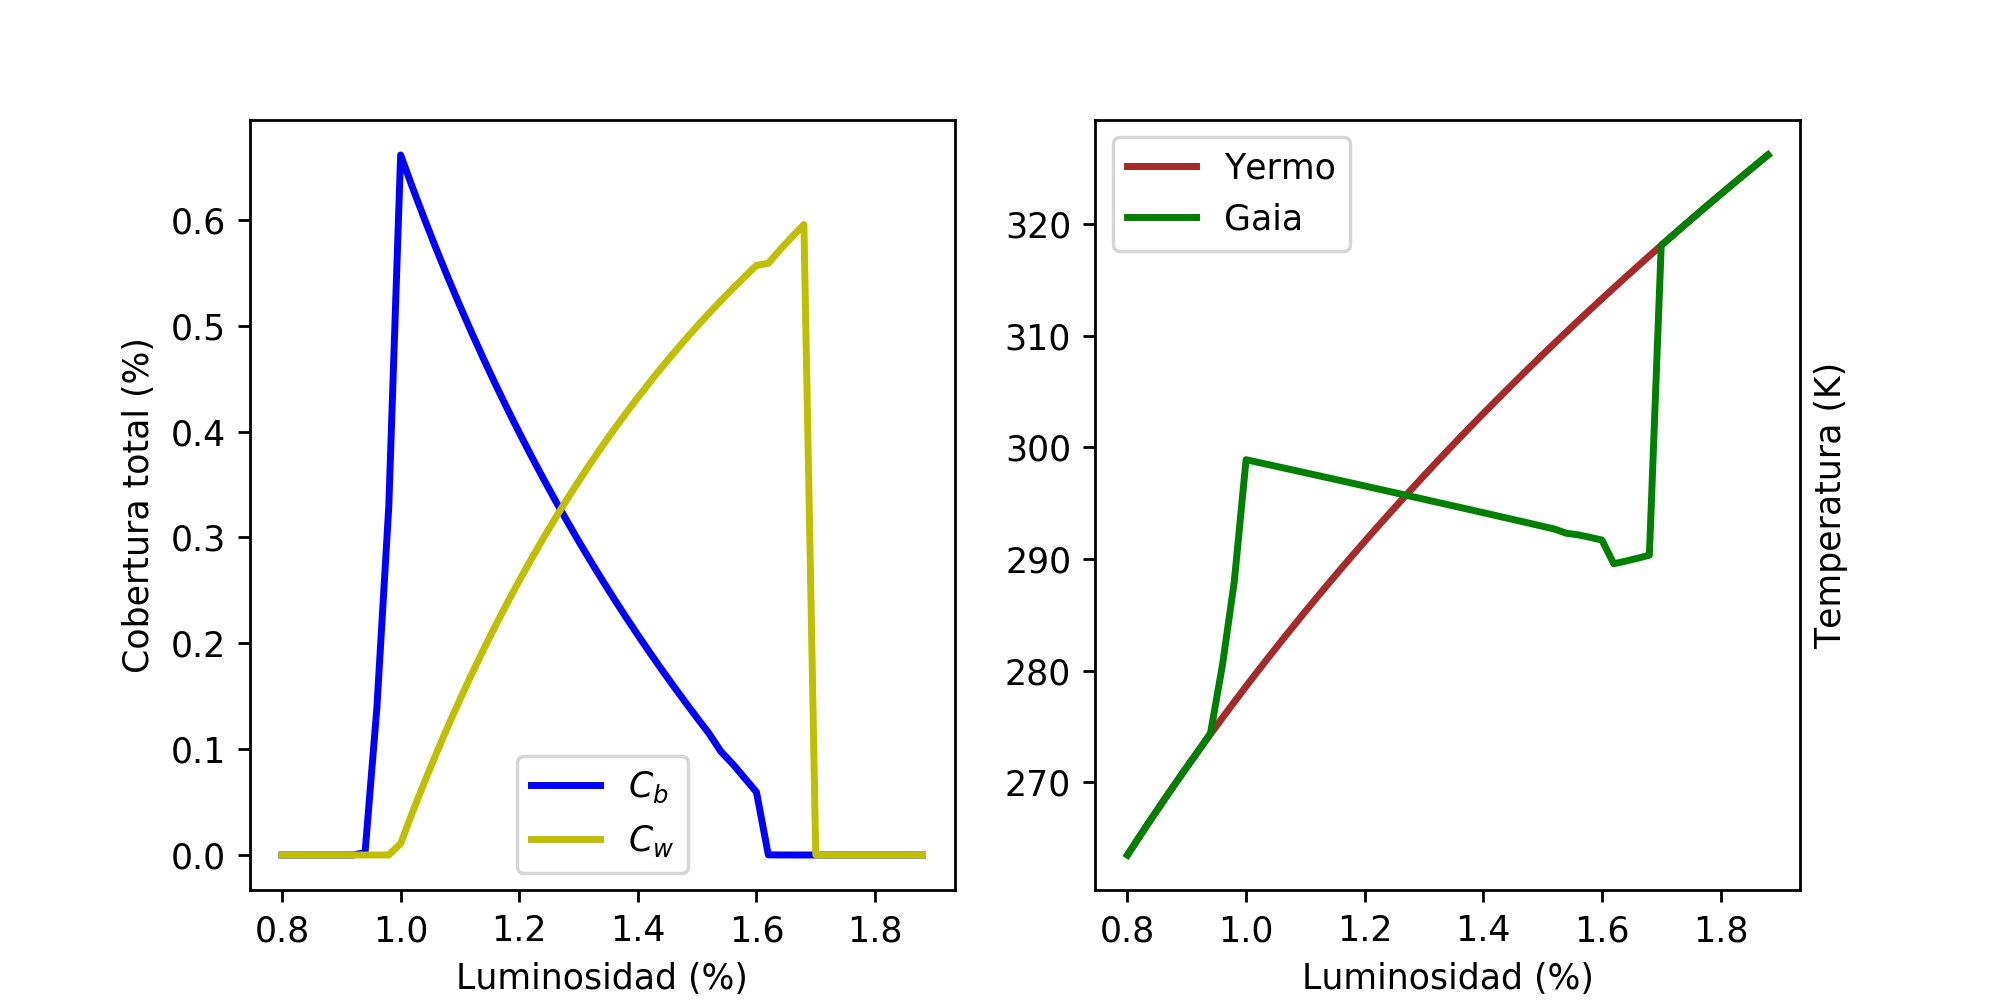

In [20]:
%matplotlib nbagg

L = np.arange(0.8, 1.9, 0.02)
Cw = np.zeros_like(L)
Cb = np.zeros_like(L)
T = np.zeros_like(L)
Ts = np.zeros_like(L)

cont = 0
for i in L:
    planet_i = DaisyWorld(i)
    sol = planet_i.equilibrate()
    Cw[cont] = sol.Cw[-1]
    Cb[cont] = sol.Cb[-1]
    T[cont] = sol.Ts[-1]
    Ts[cont] = np.power(2*planet_i.q*(1-planet_i.Ag), 1/4)
    cont += 1

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

ax0.plot(L, Cb, color='b', lw=2, label='$C_b$')
ax0.plot(L, Cw, color='y', lw=2, label='$C_w$')
ax0.set_xlabel('Luminosidad (%)')
ax0.set_ylabel('Cobertura total (%)')
ax0.legend()

ax1.plot(L, Ts, color='brown', lw=2, label='Yermo')
ax1.plot(L, T, color='g', lw=2, label='Gaia')
ax1.set_xlabel('Luminosidad (%)')
ax1.set_ylabel('Temperatura (K)')
ax1.yaxis.set_label_position("right")
ax1.legend()

plt.show()
